# 4. Statistics

## 4.5 Regularization

### 4.5.3 Example: weight decay

> Plot ridge regression applied to  1d polynomial problem
> Based on https://github.com/probml/pmtk3/blob/master/demos/polyfitRidgeLasso.m

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng()

N = 21
X_train = np.linspace(0, 20, N)
X_test = np.arange(0, 20, 0.1)

sigma = 2
w = np.array([-1.5, 1 / 9.0])
fn = lambda x: w[0] * x + w[1] * np.square(x)
y_train = fn(X_train) + rng.normal(scale=sigma, size=X_train.shape)
y_test = fn(X_test) + rng.normal(scale=sigma, size=X_test.shape)

# Reshape for fitting
X_train = X_train.reshape((-1, 1))
X_test = X_test.reshape((-1, 1))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21, 1), (21,), (200, 1), (200,))

In [3]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error

degree = 14
alpha_list = np.logspace(-10, 1.3, 10)

# Rescaling data
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Generate polynomial features
poly_features = PolynomialFeatures(degree, include_bias=False)
X_poly_train = poly_features.fit_transform(X_train_scaled)
X_poly_test = poly_features.transform(X_test_scaled)

y_pred_train = []
y_pred_test = []
mse = []
for alpha in alpha_list:
    clf = Ridge(alpha=alpha)
    clf.fit(X_poly_train, y_train)
    y_pred_train.append(clf.predict(X_poly_train))
    y_pred_test.append(clf.predict(X_poly_test))
    mse.append((
        mean_squared_error(y_pred_train[-1], y_train),
        mean_squared_error(y_pred_test[-1], y_test)
    ))
y_pred_train = np.asarray(y_pred_train)
y_pred_test = np.asarray(y_pred_test)
mse = np.asarray(mse)
    
y_pred_train.shape, y_pred_test.shape, mse.shape

((10, 21), (10, 200), (10, 2))

#### Figure 4.5: (a-c) Ridge regression applied to a degree 14 polynomial fit to 21 datasets.

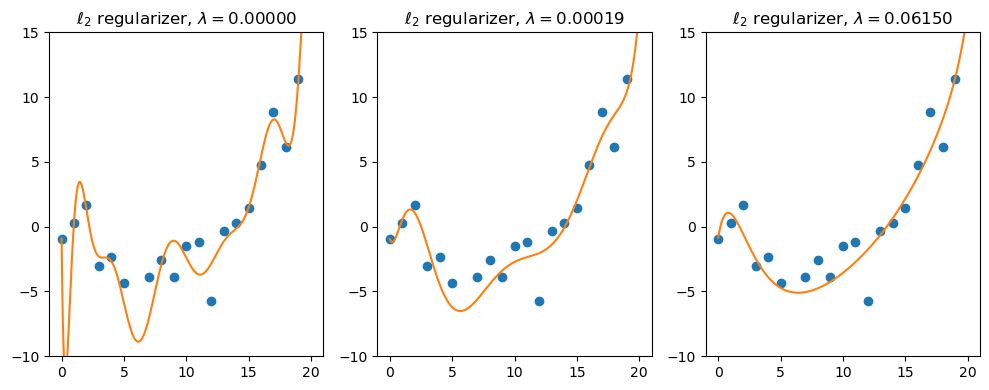

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 4), tight_layout=True)

# Plot fitted functions
for idx, ax in zip([0, 5, 7], axes):
    alpha = alpha_list[idx]
    ax.scatter(X_train, y_train, color='tab:blue')
    ax.plot(X_test, y_pred_test[idx], color='tab:orange')
    ax.set_ylim((-10, 15))
    ax.set_title(f'$\ell_2$ regularizer, $\lambda = ${alpha:.5f}')

#### Figure 4.5: (d) MSE vs. strength of regularizer. The degree of regularization increases from left to right, so model complexity decreases from left to right.

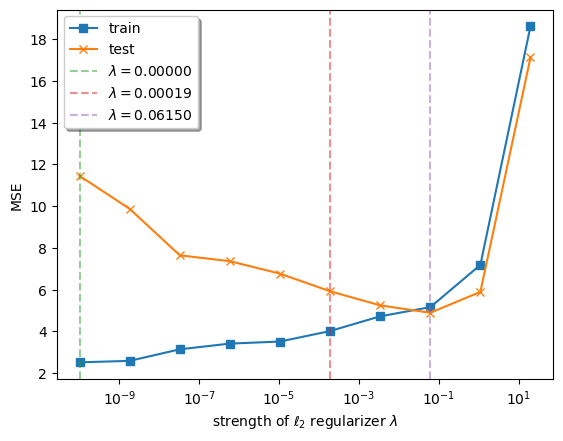

In [16]:
# Plot MSE vs degree
_, ax = plt.subplots()
ax.plot(alpha_list, mse[:, 0], color='tab:blue', marker='s', label='train')
ax.plot(alpha_list, mse[:, 1], color='tab:orange', marker='x', label='test')
for i, alpha in enumerate(alpha_list[[0, 5, 7]]):
    ax.axvline(x=alpha, ls='--', color=f'C{i+2}', alpha=0.5, label=f'$\lambda={alpha:.5f}$')
ax.set_xscale('log')
ax.set_xlabel('strength of $\ell_2$ regularizer $\lambda$')
ax.set_ylabel('MSE')
ax.legend(loc='upper left', shadow=True);

### 4.5.5 Cross-validation

#### 4.5.5.2 Example: ridge regression

In [20]:
from sklearn.metrics import make_scorer
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

from sklearn.model_selection import cross_val_score
cv_score = []
for alpha in alpha_list:
    score = cross_val_score(
        Ridge(alpha=alpha),
        X_poly_train, y_train,
        cv=5, scoring='neg_mean_squared_error'
    )
    cv_score.append(-score)
cv_score = np.asarray(cv_score)
cv_score.shape

(10, 5)

#### Figure 4.7: Ridge regression is applied to a degree 14 polynomial fit to 21 datapoints shown in Figure 4.5 for different values of the regularizer $\lambda$. The degree of regularization increases from left to right, so model complexity decreases from left to right. (b) 5-fold cross-validation estimate of test MSE; error bars are standard errors of the mean. Vertical line is the point chosen by the one standard error rule.

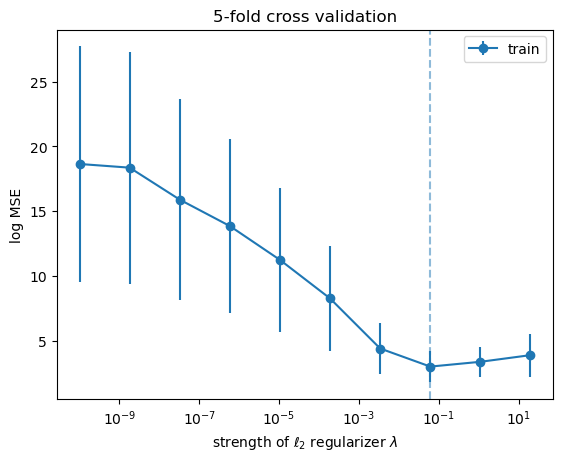

In [21]:
cv_err = np.log(cv_score.mean(axis=-1))
cv_se = np.log(cv_score.std(axis=-1) / np.sqrt(cv_score.shape[-1]))

_, ax = plt.subplots()
ax.errorbar(
    alpha_list, cv_err, yerr=cv_se / 2,
    fmt='-o', color='tab:blue', label='train'
)
ax.axvline(x=alpha_list[np.argmin(cv_err)], ls='--', color='tab:blue', alpha=0.5)
ax.set_xscale('log')
ax.set_xlabel('strength of $\ell_2$ regularizer $\lambda$')
ax.set_ylabel('log MSE')
ax.set_title('5-fold cross validation')
ax.legend(loc='upper right');